In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
# import torch
!pwd

/c/Users/34603/Documents/GitHub/MCM2024/6-相关资料/氪金/第三问结果/第三问结果


In [8]:
src_data = pd.read_excel("./Wimbledon_featured_matches.xlsx")

In [10]:
import numpy as np

# 计算跑动差距
def count_run(pd_frame):
    run_arvg = 13.94  # 平均跑动差距
    d_now_run = pd_frame["p1_distance_run"] - pd_frame["p2_distance_run"]  # 当前跑动差距
    if np.abs(d_now_run) > run_arvg:  # 如果当前跑动差距绝对值大于平均值
        return -d_now_run / max(pd_frame["p1_distance_run"], pd_frame["p2_distance_run"]) * 0.2  # 返回归一化后的结果
    return -(pd_frame["p1_distance_run"] - pd_frame["p2_distance_run"]) / run_arvg * 0.2  # 返回归一化后的结果

# 计算失误
def count_fault(pd_frame):
    ans = 0
    if pd_frame["p1_double_fault"] == 1 or pd_frame["p1_unf_err"] == 1:  # 如果p1双误或非强制性失误
        ans = -1
    elif pd_frame["p2_double_fault"] == 1 or pd_frame["p2_unf_err"] == 1:  # 如果p2双误或非强制性失误
        ans = 1
    return ans * 0.2  # 返回归一化后的结果

# 计算发球者
def count_sev(pd_frame):
    ans = 0
    if pd_frame["server"] == 1:  # 如果p1为发球者
        ans = 1
    elif pd_frame["server"] == 2:  # 如果p2为发球者
        ans = -1
    return ans * 0.2  # 返回归一化后的结果

# 计算胜负
def count_win(pd_frame):
    ans = 0
    if pd_frame["p1_points_won"] > pd_frame["p2_points_won"]:  # 如果p1获胜
        ans = 1
    elif pd_frame["p1_points_won"] < pd_frame["p2_points_won"]:  # 如果p2获胜
        ans = -1
    return ans  # 返回结果

# 计算连续三局得分情况
def count_three_numbers(arr):
    one_arr = np.zeros(len(arr))  # 初始化长度与输入数组相同的全零数组
    for i in range(len(arr) - 4):
        sub_array = arr[i:i + 5]  # 获取连续五局的得分情况
        if sub_array.count(1) == 4:  # 如果连续四局p1得分
            one_arr[i + 4] = 1
        elif sub_array.count(2) == 4:  # 如果连续四局p2得分
            one_arr[i + 4] = -1
    return one_arr  # 返回结果数组

# 滑动窗口平均值计算
def sliding_window_average(arr):
    averages = []  # 初始化存储平均值的列表
    for i in range(len(arr) - 2):
        window_sum = arr[i] + arr[i + 1] + arr[i + 2]  # 计算窗口内三局得分总和
        window_average = window_sum / 3.0  # 计算窗口内三局得分的平均值
        averages.append(window_average)  # 将平均值添加到列表中
    averages.append(arr[-2])  # 添加倒数第二个元素到新列表中
    averages.append(arr[-1])  # 添加最后一个元素到新列表中
    return averages  # 返回滑动窗口平均值列表


In [4]:
list_match = ["2023-wimbledon-1301","2023-wimbledon-1302","2023-wimbledon-1303","2023-wimbledon-1304",
              "2023-wimbledon-1305","2023-wimbledon-1306","2023-wimbledon-1307","2023-wimbledon-1308",
              "2023-wimbledon-1309","2023-wimbledon-1310","2023-wimbledon-1311","2023-wimbledon-1312",
             "2023-wimbledon-1313","2023-wimbledon-1314","2023-wimbledon-1315","2023-wimbledon-1401",
             "2023-wimbledon-1402","2023-wimbledon-1403","2023-wimbledon-1404","2023-wimbledon-1405",
             "2023-wimbledon-1406","2023-wimbledon-1407","2023-wimbledon-1408","2023-wimbledon-1409",
             "2023-wimbledon-1501","2023-wimbledon-1502","2023-wimbledon-1503","2023-wimbledon-1504",
             "2023-wimbledon-1601","2023-wimbledon-1602","2023-wimbledon-1701"]

In [11]:
list_match =["2023-wimbledon-1303"]

In [12]:
# 初始化空列表
all_list = []         # 存储每场比赛的指标
all_list_label = []   # 存储每场比赛的标签

# 遍历比赛列表
for j in list_match:
    # 获取当前比赛数据
    n_data_aim = src_data[src_data["match_id"] == j]

    # 计算连续三局得分情况并加权
    AB_array = count_three_numbers(list(n_data_aim["point_victor"].values)) * 0.4

    # 初始化其他指标的数组
    other_index_run = np.zeros(len(n_data_aim))
    other_index_fault = np.zeros(len(n_data_aim))
    other_index_sev = np.zeros(len(n_data_aim))
    other_index_win = np.zeros(len(n_data_aim))
    other_index = np.zeros(len(n_data_aim))

    # 计算每局的其他指标
    for i in range(len(n_data_aim)):
        other_index_run[i] = count_run(n_data_aim.iloc[i])
        other_index_fault[i] = count_fault(n_data_aim.iloc[i])
        other_index_sev[i] = count_sev(n_data_aim.iloc[i])
        other_index_win[i] = count_win(n_data_aim.iloc[i])
        other_index[i] = other_index_run[i] + other_index_fault[i] + other_index_sev[i]

    # 计算最终指标
    dst_index = other_index + AB_array

    # 计算滑动窗口平均值
    slide_dst_index = sliding_window_average(dst_index)

    # 将指标列表添加到总列表中
    all_list.append(slide_dst_index)

    # 将比赛标签添加到总标签列表中
    all_list_label.append(n_data_aim["set_victor"].values[-1])

    # 打印比赛信息
    print(j, round(sum(slide_dst_index), 2), n_data_aim["set_victor"].values[-1])


2023-wimbledon-1303 -16.45 2


In [13]:
def find_tran(my_list, num=10):
    """
    在输入列表中寻找变化点

    参数:
    my_list (list): 输入的列表
    num (int): 用于检测变化的窗口大小，默认为10

    返回:
    list: 包含变化点的列表，每个元素是一个包含索引和值的子列表
    """
    dst_tran = []  # 存储变化点的列表
    i = 0

    while i < len(my_list) - num - 1:
        if np.abs(my_list[i + num] - my_list[i]) >= 2.5:  # 如果窗口内的变化大于等于2.5
            dst_tran.append([i, my_list[i]])  # 将变化点的索引和值添加到列表中
            i += num
        i += 1

    return dst_tran


3


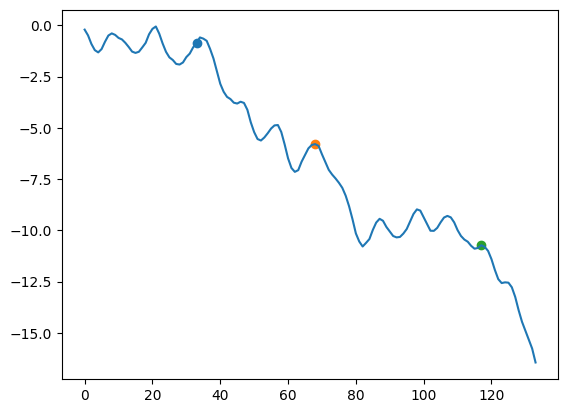

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化数组
cnt_m = np.zeros(len(slide_dst_index))
cnt_m[0] = slide_dst_index[0]

# 计算累积值
for i in range(1, len(slide_dst_index)):
    cnt_m[i] = slide_dst_index[i] + cnt_m[i - 1]

# 寻找变化点
tran_point = find_tran(cnt_m)

# 打印变化点个数
print(len(tran_point))

# 绘制图形
plt.plot(cnt_m)
for i in tran_point:
    plt.scatter(i[0], i[1])
plt.show()
